# Behavioral Clustering Analysis: San Francisco & San Jose Combined

**Project:** A Tale of Two Cities - Comparative Public Safety Analysis

**Purpose:** This notebook performs behavioral clustering using K-Means to identify distinct incident patterns across both cities based on temporal features, incident types, and contextual characteristics.

**Key Objectives:**
- Engineer temporal and behavioral features from incident data
- Identify 4-6 distinct behavioral incident profiles using K-Means
- Compare incident behavior patterns between San Francisco and San Jose
- Validate clustering quality using multiple metrics
- Generate actionable insights for public safety resource allocation

**Expected Deliverables:**
- 4-6 behavioral incident profiles with statistical characteristics
- 5+ professional visualizations (temporal patterns, radar charts, heatmaps)
- Cross-city behavioral comparison analysis
- Validation metrics (silhouette scores, statistical tests)
- Key insights on incident behavior types

---

## Methodology Overview

**Algorithm:** K-Means clustering with optimal K selection (4-6 expected)

**Feature Categories:**
1. **Temporal Features:** Hour, day of week, month, season, weekend/weekday flags
2. **Incident Characteristics:** High-level categories, subcategory distributions
3. **Contextual Features:** Police districts, geographic patterns
4. **Derived Metrics:** Incident frequency patterns, temporal densities

**Analysis Approach:**
- Feature engineering and scaling (StandardScaler)
- Optimal K determination (Elbow Method + Silhouette Analysis)
- Cluster profiling and interpretation
- Cross-city behavioral pattern comparison
- Statistical validation (chi-squared tests, silhouette scores)

---

In [ ]:
## 1. Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Clustering and ML
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, \
                            silhouette_score, \
                            calinski_harabasz_score, \
                            davies_bouldin_score

# Statistical tests
from scipy.stats import chi2_contingency

# Date/time handling
from datetime import datetime

# Plot settings
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")
sns.set_palette("husl")

## 2. Load and Combine Data

**Objective:** Load cleaned incident data from both cities and combine into a single dataset for comparative behavioral analysis.

**Data Sources:**
- San Francisco: `../data/processed/sf_incidents_cleaned.csv`
- San Jose: `../data/processed/sj_calls_cleaned.csv`

**Expected Outcome:** Combined dataset with ~200K+ incidents, city identifier column, and harmonized features for clustering.

In [5]:
# Load San Francisco data
print("\n Loading San Francisco data...")
df_sf = pd.read_csv(
    '../data/processed/sf_incidents_cleaned.csv',
    index_col='Incident DateTime',
    parse_dates=True
)
print(f"    SF loaded: {len(df_sf):,} incidents")
print(f"    Date range: {df_sf.index.min().date()} to {df_sf.index.max().date()}")

# Load San Jose data
print("\n Loading San Jose data...")
df_sj = pd.read_csv(
    '../data/processed/sj_calls_cleaned.csv',
    index_col='Incident DateTime',
    parse_dates=True
)
print(f"    SJ loaded: {len(df_sj):,} incidents")
print(f"    Date range: {df_sj.index.min().date()} to {df_sj.index.max().date()}")

# Add city identifier column
df_sf['City'] = 'San Francisco'
df_sj['City'] = 'San Jose'

# Combine datasets
print("\n Combining datasets...")
df_combined = pd.concat([df_sf, df_sj], axis=0)
print(f"    Combined dataset: {len(df_combined):,} total incidents")

# Display combined dataset info
print("\n" + "="*80)
print("COMBINED DATASET SUMMARY")
print("="*80)
print(f"\n Total incidents: {len(df_combined):,}")
print(f"    San Francisco: {len(df_sf):,} ({100*len(df_sf)/len(df_combined):.1f}%)")
print(f"    San Jose: {len(df_sj):,} ({100*len(df_sj)/len(df_combined):.1f}%)")
print(f"\n Combined date range: {df_combined.index.min().date()} to {df_combined.index.max().date()}")
print(f"\n Available columns: {df_combined.columns.tolist()}")


 Loading San Francisco data...
    SF loaded: 823,541 incidents
    Date range: 2018-01-01 to 2025-11-16

 Loading San Jose data...
    SJ loaded: 1,170,667 incidents
    Date range: 2018-01-01 to 2025-11-15

 Combining datasets...
    Combined dataset: 1,994,208 total incidents

COMBINED DATASET SUMMARY

 Total incidents: 1,994,208
    San Francisco: 823,541 (41.3%)
    San Jose: 1,170,667 (58.7%)

 Combined date range: 2018-01-01 to 2025-11-16

 Available columns: ['Incident_High_Level_Category', 'Resolution', 'Neighborhood', 'Police_District', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month', 'Year', 'Day_of_Week', 'Day_of_Week_Name', 'Month_Name', 'Quarter', 'Is_Weekend', 'City']


In [7]:
temporal_features = ['Hour', 'Day', 'Month', 'Year', 'Day_of_Week', 'Day_of_Week_Name', 
                     'Month_Name', 'Quarter', 'Is_Weekend']
for feature in temporal_features:
    sf_status = True if feature in df_sf.columns else False
    sj_status = True if feature in df_sj.columns else False
    if not sf_status:
        print(f"SF missing temporal feature: {feature}")
    if not sj_status:
        print(f"SJ missing temporal feature: {feature}")
        

categorical_features = ['Incident_High_Level_Category', 'Police_District', 'Neighborhood']
for feature in categorical_features:
    sf_status = True if feature in df_sf.columns else False
    sj_status = True if feature in df_sj.columns else False
    if not sf_status:
        print(f"SF missing categorical feature: {feature}")
    if not sj_status:
        print(f"SJ missing categorical feature: {feature}")

print("\nSample Data - San Francisco:")
print(df_sf[['Hour', 'Day_of_Week_Name', 'Is_Weekend', 'Incident_High_Level_Category']].head(2))

print("\nSample Data - San Jose:")
print(df_sj[['Hour', 'Day_of_Week_Name', 'Is_Weekend', 'Incident_High_Level_Category']].head(2))



Sample Data - San Francisco:
                     Hour Day_of_Week_Name  Is_Weekend  \
Incident DateTime                                        
2025-08-27 00:37:00     0        Wednesday           0   
2025-07-17 15:00:00    15         Thursday           0   

                    Incident_High_Level_Category  
Incident DateTime                                 
2025-08-27 00:37:00                      Violent  
2025-07-17 15:00:00                        Fraud  

Sample Data - San Jose:
                     Hour Day_of_Week_Name  Is_Weekend  \
Incident DateTime                                        
2018-01-01 00:00:02     0           Monday           0   
2018-01-01 00:00:15     0           Monday           0   

                    Incident_High_Level_Category  
Incident DateTime                                 
2018-01-01 00:00:02                        Other  
2018-01-01 00:00:15                        Alarm  


### Feature Inspection Results

- **All temporal features present** in both datasets
  - Hour (0-23), Day, Month, Year
  - Day_of_Week (0-6), Day_of_Week_Name
  - Quarter (1-4), Is_Weekend (0/1)
- **All categorical features present** in both datasets
  - Incident_High_Level_Category
  - Police_District, Neighborhood
- **Feature structure is identical** between cities

---

## 3. Feature Selection for Behavioral Clustering

**Objective:** Select and prepare features that capture incident **behavior patterns** for K-Means clustering.

**Key Insight:** 
We're discovering behavioral profiles (e.g., "Late-Night Entertainment District Incidents"), not just temporal trends.

**Selected Clustering Features:**

1. **Temporal Behavior (4 features):**
   - `Hour` - Time-of-day activity pattern (0-23)
   - `Day_of_Week` - Weekday pattern (0=Monday, 6=Sunday)
   - `Is_Weekend` - Weekend flag (0/1)
   - `Quarter` - Seasonal pattern (1-4)

2. **Incident Behavior (1 feature):**
   - `Incident_High_Level_Category` - Crime type (will be encoded)

3. **Geographic Behavior (1 feature):**
   - `Police_District` - District-level patterns (will be encoded)

4. **City Identifier (1 feature):**
   - `City` - For cross-city comparison (SF vs SJ)

**Total Features for Clustering:** 7 base features → Will expand after encoding categorical variables

**Why These Features?**
- Capture **when** incidents happen (temporal)
- Capture **what type** (category)
- Capture **where generally** (district, not exact coordinates)
- Enable **cross-city comparison** (city identifier)

**Expected Outcome:** Feature matrix ready for K-Means with scaled numerical features and encoded categorical variables.

---

In [10]:
clustering_features = {
    'temporal': ['Hour', 'Day_of_Week', 'Is_Weekend', 'Quarter'],
    'categorical': ['Incident_High_Level_Category', 'Police_District'],
    'identifier': ['City']
}

print("\n Selected Feature Groups:")
print(f"\n    Temporal Features ({len(clustering_features['temporal'])}):")
for feat in clustering_features['temporal']:
    print(f"      • {feat}")

print(f"\n    Categorical Features ({len(clustering_features['categorical'])}):")
for feat in clustering_features['categorical']:
    print(f"      • {feat}")

print(f"\n    Identifier ({len(clustering_features['identifier'])}):")
for feat in clustering_features['identifier']:
    print(f"      • {feat}")

# Create working dataset with selected features
all_features = (clustering_features['temporal'] + 
                clustering_features['categorical'] + 
                clustering_features['identifier'])

df_clustering = df_combined[all_features].copy()

print(f"\n Clustering dataset created: {len(df_clustering):,} incidents")
print(f"   • Features: {len(all_features)} columns")
print(f"   • SF incidents: {len(df_clustering[df_clustering['City']=='San Francisco']):,}")
print(f"   • SJ incidents: {len(df_clustering[df_clustering['City']=='San Jose']):,}")

# Display feature value ranges
print("\n Feature Value Ranges:")
print(f"\n   Hour: {df_clustering['Hour'].min()}-{df_clustering['Hour'].max()}")
print(f"   Day_of_Week: {df_clustering['Day_of_Week'].min()}-{df_clustering['Day_of_Week'].max()}")
print(f"   Is_Weekend: {df_clustering['Is_Weekend'].unique()}")
print(f"   Quarter: {df_clustering['Quarter'].unique()}")
print(f"   Incident Categories: {df_clustering['Incident_High_Level_Category'].nunique()} unique")
print(f"   Police Districts: {df_clustering['Police_District'].nunique()} unique")


 Selected Feature Groups:

    Temporal Features (4):
      • Hour
      • Day_of_Week
      • Is_Weekend
      • Quarter

    Categorical Features (2):
      • Incident_High_Level_Category
      • Police_District

    Identifier (1):
      • City

 Clustering dataset created: 1,994,208 incidents
   • Features: 7 columns
   • SF incidents: 823,541
   • SJ incidents: 1,170,667

 Feature Value Ranges:

   Hour: 0-23
   Day_of_Week: 0-6
   Is_Weekend: [0 1]
   Quarter: [3 2 1 4]
   Incident Categories: 8 unique
   Police Districts: 12 unique


In [25]:
print("\nAdding interaction features to capture behavioral patterns...")

print("\n[1/4] Creating time-of-day behavioral features...")

df_clustering['Night_Shift'] = ((df_clustering['Hour'] >= 22) | (df_clustering['Hour'] <= 5)).astype(int)
df_clustering['Early_Morning'] = ((df_clustering['Hour'] >= 6) & (df_clustering['Hour'] <= 8)).astype(int)
df_clustering['Business_Hours'] = ((df_clustering['Hour'] >= 9) & (df_clustering['Hour'] <= 17)).astype(int)
df_clustering['Evening_Hours'] = ((df_clustering['Hour'] >= 18) & (df_clustering['Hour'] <= 21)).astype(int)

print(f"    Night_Shift (10pm-5am): {df_clustering['Night_Shift'].sum():,} incidents")
print(f"    Early_Morning (6am-8am): {df_clustering['Early_Morning'].sum():,} incidents")
print(f"    Business_Hours (9am-5pm): {df_clustering['Business_Hours'].sum():,} incidents")
print(f"    Evening_Hours (6pm-9pm): {df_clustering['Evening_Hours'].sum():,} incidents")

print("\n[2/4] Creating weekend interaction features...")

df_clustering['Weekend_Night'] = (df_clustering['Is_Weekend'] * df_clustering['Night_Shift']).astype(int)
df_clustering['Weekend_Evening'] = (df_clustering['Is_Weekend'] * df_clustering['Evening_Hours']).astype(int)
df_clustering['Weekday_Business'] = ((1 - df_clustering['Is_Weekend']) * df_clustering['Business_Hours']).astype(int)

print(f"    Weekend_Night: {df_clustering['Weekend_Night'].sum():,} incidents")
print(f"    Weekend_Evening: {df_clustering['Weekend_Evening'].sum():,} incidents")
print(f"    Weekday_Business: {df_clustering['Weekday_Business'].sum():,} incidents")

print("\n[3/4] Creating seasonal behavioral features...")

df_clustering['Summer_Season'] = df_clustering['Quarter'].isin([2, 3]).astype(int)  # Q2, Q3
df_clustering['Winter_Season'] = df_clustering['Quarter'].isin([1, 4]).astype(int)  # Q1, Q4

print(f"    Summer_Season (Apr-Sep): {df_clustering['Summer_Season'].sum():,} incidents")
print(f"    Winter_Season (Oct-Mar): {df_clustering['Winter_Season'].sum():,} incidents")

print("\n[4/4] Creating advanced time interaction features...")

df_clustering['Morning_Rush'] = ((df_clustering['Hour'] >= 7) & (df_clustering['Hour'] <= 9) & 
                                  (df_clustering['Is_Weekend'] == 0)).astype(int)
df_clustering['Evening_Rush'] = ((df_clustering['Hour'] >= 16) & (df_clustering['Hour'] <= 18) & 
                                  (df_clustering['Is_Weekend'] == 0)).astype(int)

df_clustering['Party_Hours'] = ((df_clustering['Hour'] >= 22) | (df_clustering['Hour'] <= 2)) & \
                                (df_clustering['Is_Weekend'] == 1).astype(int)

print(f"    Morning_Rush (7am-9am weekdays): {df_clustering['Morning_Rush'].sum():,} incidents")
print(f"    Evening_Rush (4pm-6pm weekdays): {df_clustering['Evening_Rush'].sum():,} incidents")
print(f"    Party_Hours (10pm-2am weekends): {df_clustering['Party_Hours'].sum():,} incidents")


Adding interaction features to capture behavioral patterns...

[1/4] Creating time-of-day behavioral features...
    Night_Shift (10pm-5am): 482,328 incidents
    Early_Morning (6am-8am): 165,417 incidents
    Business_Hours (9am-5pm): 929,886 incidents
    Evening_Hours (6pm-9pm): 416,577 incidents

[2/4] Creating weekend interaction features...
    Weekend_Night: 168,360 incidents
    Weekend_Evening: 118,699 incidents
    Weekday_Business: 690,552 incidents

[3/4] Creating seasonal behavioral features...
    Summer_Season (Apr-Sep): 1,039,570 incidents
    Winter_Season (Oct-Mar): 954,638 incidents

[4/4] Creating advanced time interaction features...
    Morning_Rush (7am-9am weekdays): 166,587 incidents
    Evening_Rush (4pm-6pm weekdays): 249,631 incidents
    Party_Hours (10pm-2am weekends): 136,001 incidents


In [26]:
# Update clustering features dictionary
clustering_features_enhanced = {
    'temporal_base': ['Hour', 'Day_of_Week', 'Is_Weekend', 'Quarter'],
    'temporal_engineered': [
        'Night_Shift', 'Early_Morning', 'Business_Hours', 'Evening_Hours',
        'Weekend_Night', 'Weekend_Evening', 'Weekday_Business',
        'Summer_Season', 'Winter_Season',
        'Morning_Rush', 'Evening_Rush', 'Party_Hours'
    ],
    'categorical': ['Incident_High_Level_Category', 'Police_District'],
    'identifier': ['City']
}

print(f"\n Enhanced Feature Counts:")
print(f"   Base temporal features: {len(clustering_features_enhanced['temporal_base'])}")
print(f"   Engineered temporal features: {len(clustering_features_enhanced['temporal_engineered'])}")
print(f"   Categorical features: {len(clustering_features_enhanced['categorical'])}")
print(f"   Total features before encoding: {len(clustering_features_enhanced['temporal_base']) + len(clustering_features_enhanced['temporal_engineered']) + len(clustering_features_enhanced['categorical'])}")


 Enhanced Feature Counts:
   Base temporal features: 4
   Engineered temporal features: 12
   Categorical features: 2
   Total features before encoding: 18


In [27]:
# Display sample
print("\n Sample of clustering dataset:")
print(df_clustering.head(3))


 Sample of clustering dataset:
                     Hour  Day_of_Week  Is_Weekend  Quarter  \
Incident DateTime                                             
2025-08-27 00:37:00     0            2           0        3   
2025-07-17 15:00:00    15            3           0        3   
2025-08-23 21:30:00    21            5           1        3   

                    Incident_High_Level_Category Police_District  \
Incident DateTime                                                  
2025-08-27 00:37:00                      Violent            Park   
2025-07-17 15:00:00                        Fraud            Park   
2025-08-23 21:30:00               Theft/Property        Northern   

                              City  Night_Shift  Early_Morning  \
Incident DateTime                                                
2025-08-27 00:37:00  San Francisco            1              0   
2025-07-17 15:00:00  San Francisco            0              0   
2025-08-23 21:30:00  San Francisco            0

## 4. Feature Encoding and Scaling

**Objective:** Transform features into numerical format suitable for K-Means clustering.

**Why This Step is Critical:**
- K-Means requires all features to be numerical
- Features must be on similar scales (Hour: 0-23 vs Is_Weekend: 0-1)
- Categorical variables need encoding (e.g., "Theft" → numerical representation)

**Transformation Steps:**

1. **One-Hot Encoding for Categorical Features:**
   - `Incident_High_Level_Category` → Multiple binary columns
   - `Police_District` → Multiple binary columns
   - Prevents ordinal assumptions (no "Theft > Assault" relationship)

2. **Standardization for Numerical Features:**
   - Hour, Day_of_Week, Quarter → Mean=0, StdDev=1
   - Ensures equal weight in distance calculations
   - Uses StandardScaler from scikit-learn

3. **Feature Matrix Creation:**
   - Combine encoded categorical + scaled numerical
   - Final matrix ready for K-Means algorithm

**Expected Outcome:** Numerical feature matrix with ~20-30 dimensions (after encoding) ready for clustering.

---

In [29]:
# Step 1: One-Hot Encode Categorical Features
print("\n[1/3] One-Hot Encoding Categorical Features...")

categorical_cols = ['Incident_High_Level_Category', 'Police_District']
df_encoded = pd.get_dummies(
    df_clustering, 
    columns=categorical_cols,
    prefix=categorical_cols,
    drop_first=True  # Avoid multicollinearity
)

print("One Hot Encoding Completed.")

# Step 2: Separate target labels (City) from features
print("\n[2/3] Separating City Identifier...")
city_labels = df_encoded['City'].copy()
df_encoded = df_encoded.drop('City', axis=1)

print(f"   City labels stored separately")
print(f"   Feature matrix shape: {df_encoded.shape}")

# Step 3: Scale Numerical Features
print("\n[3/3] Scaling Features with StandardScaler...")

scaler = StandardScaler()
feature_matrix = scaler.fit_transform(df_encoded)

print(f"   Scaled feature matrix shape: {feature_matrix.shape}")
print(f"   Total features for clustering: {feature_matrix.shape[1]}")


[1/3] One-Hot Encoding Categorical Features...
One Hot Encoding Completed.

[2/3] Separating City Identifier...
   City labels stored separately
   Feature matrix shape: (1994208, 34)

[3/3] Scaling Features with StandardScaler...
   Scaled feature matrix shape: (1994208, 34)
   Total features for clustering: 34


In [30]:
# Store feature names for later interpretation
feature_names = df_encoded.columns.tolist()
print(f" Features: {feature_names}")

print("\n Feature Categories After Encoding:")
temporal_count = len([f for f in feature_names if f in ['Hour', 'Day_of_Week', 'Is_Weekend', 'Quarter']])
temporal_count_engineered = len([f for f in feature_names if f in ['Night_Shift', 'Early_Morning', 'Business_Hours', 'Evening_Hours',
                                                'Weekend_Night', 'Weekend_Evening', 'Weekday_Business',
                                                'Summer_Season', 'Winter_Season',
                                                'Morning_Rush', 'Evening_Rush', 'Party_Hours']])
category_count = len([f for f in feature_names if 'Incident_High_Level_Category' in f])
district_count = len([f for f in feature_names if 'Police_District' in f])

print(f"   Temporal features: {temporal_count}")
print(f"   Engineered temporal features: {temporal_count_engineered}")
print(f"   Incident category features: {category_count}")
print(f"   Police district features: {district_count}")
print(f"   Total: {len(feature_names)}")

print(f"\nReady for K-Means clustering:")
print(f"   Incidents: {feature_matrix.shape[0]:,}")
print(f"   Features: {feature_matrix.shape[1]}")

 Features: ['Hour', 'Day_of_Week', 'Is_Weekend', 'Quarter', 'Night_Shift', 'Early_Morning', 'Business_Hours', 'Evening_Hours', 'Weekend_Night', 'Weekend_Evening', 'Weekday_Business', 'Summer_Season', 'Winter_Season', 'Morning_Rush', 'Evening_Rush', 'Party_Hours', 'Incident_High_Level_Category_Disturbance/Suspicious', 'Incident_High_Level_Category_Fraud', 'Incident_High_Level_Category_Non-Criminal/Admin', 'Incident_High_Level_Category_Other', 'Incident_High_Level_Category_Theft/Property', 'Incident_High_Level_Category_Traffic/Vehicle', 'Incident_High_Level_Category_Violent', 'Police_District_Central', 'Police_District_Ingleside', 'Police_District_Mission', 'Police_District_Northern', 'Police_District_Out of SF', 'Police_District_Park', 'Police_District_Richmond', 'Police_District_San Jose', 'Police_District_Southern', 'Police_District_Taraval', 'Police_District_Tenderloin']

 Feature Categories After Encoding:
   Temporal features: 4
   Engineered temporal features: 12
   Incident categ

### Feature Encoding and Scaling

1. **One-hot encoded** categorical variables (Incident_High_Level_Category, Police_District)
2. **Separated** City identifier for post-clustering analysis
3. **Standardized** all features using StandardScaler (mean=0, std=1)
4. **Created** final numerical feature matrix for K-Means

## 5. Determine Optimal Number of Clusters (K)

**Objective:** Use Elbow Method and Silhouette Analysis to determine the optimal number of behavioral profiles (clusters).

**Methods Used:**

1. **Elbow Method:**
   - Plots inertia (within-cluster sum of squares) vs. K
   - Look for "elbow" where inertia decrease slows down
   - Indicates diminishing returns from adding more clusters

2. **Silhouette Analysis:**
   - Measures how similar incidents are to their own cluster vs. other clusters
   - Score range: -1 (poor) to +1 (excellent)
   - Higher average silhouette score indicates better-defined clusters

3. **Additional Validation Metrics:**
   - Calinski-Harabasz Score: Ratio of between-cluster to within-cluster variance (higher is better)
   - Davies-Bouldin Index: Average similarity between clusters (lower is better)

**Testing K Range:** 2 to 10 clusters

---

In [ ]:
def create_stratified_sample(feature_matrix, city_labels, sample_size=50000, random_seed=42):
    """
    Create stratified sample maintaining city distribution.
    
    Parameters:
    -----------
    feature_matrix : ndarray
        Full feature matrix for clustering
    city_labels : Series
        City identifier for each incident
    sample_size : int
        Target sample size
    random_seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple : (sampled_feature_matrix, sampled_city_labels, sample_indices)
    """
    print(f"\nOriginal dataset size: {feature_matrix.shape[0]:,} incidents")
    print(f"Features: {feature_matrix.shape[1]}")
    
    if len(feature_matrix) <= sample_size:
        print("\nDataset size is manageable. Using full dataset.")
        return feature_matrix, city_labels, np.arange(len(feature_matrix))
    
    print(f"\nDataset is large. Creating stratified sample of {sample_size:,} incidents...")
    
    # Get indices for each city
    sf_indices = np.where(city_labels == 'San Francisco')[0]
    sj_indices = np.where(city_labels == 'San Jose')[0]
    
    # Calculate proportional sample sizes
    sf_sample_size = int(sample_size * len(sf_indices) / len(city_labels))
    sj_sample_size = sample_size - sf_sample_size
    
    # Create stratified sample
    np.random.seed(random_seed)
    sample_indices = np.concatenate([
        np.random.choice(sf_indices, sf_sample_size, replace=False),
        np.random.choice(sj_indices, sj_sample_size, replace=False)
    ])
    
    feature_matrix_sample = feature_matrix[sample_indices]
    city_labels_sample = city_labels.iloc[sample_indices]
    
    print(f"   Sample created: {len(feature_matrix_sample):,} incidents")
    print(f"   SF in sample: {(city_labels_sample == 'San Francisco').sum():,} "
          f"({100*(city_labels_sample == 'San Francisco').sum()/len(city_labels_sample):.1f}%)")
    print(f"   SJ in sample: {(city_labels_sample == 'San Jose').sum():,} "
          f"({100*(city_labels_sample == 'San Jose').sum()/len(city_labels_sample):.1f}%)")
    
    return feature_matrix_sample, city_labels_sample, sample_indices


def fit_kmeans_for_k(feature_matrix, k, random_seed=42):
    """
    Fit K-Means for a specific K value and calculate validation metrics.
    
    Parameters:
    -----------
    feature_matrix : ndarray
        Feature matrix for clustering
    k : int
        Number of clusters
    random_seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing all metrics
    """
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=random_seed, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(feature_matrix)
    
    # Calculate metrics
    metrics = {
        'k': k,
        'inertia': kmeans.inertia_,
        'silhouette': silhouette_score(feature_matrix, cluster_labels, sample_size=10000),
        'calinski_harabasz': calinski_harabasz_score(feature_matrix, cluster_labels),
        'davies_bouldin': davies_bouldin_score(feature_matrix, cluster_labels)
    }
    
    return metrics, kmeans


def test_k_range(feature_matrix, k_range, verbose=True):
    """
    Test multiple K values and collect validation metrics.
    
    Parameters:
    -----------
    feature_matrix : ndarray
        Feature matrix for clustering
    k_range : range
        Range of K values to test
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    DataFrame : Results with all metrics for each K
    """
    results = []
    
    if verbose:
        print(f"\nTesting K values from {min(k_range)} to {max(k_range)}...")
    
    for k in k_range:
        if verbose:
            print(f"Testing K={k}...", end=" ", flush=True)
        
        metrics, _ = fit_kmeans_for_k(feature_matrix, k)
        results.append(metrics)
        
        if verbose:
            print(f"Silhouette: {metrics['silhouette']:.4f}, Inertia: {metrics['inertia']:,.0f}")
    
    return pd.DataFrame(results)


def recommend_optimal_k(results_df, primary_metric='silhouette'):
    """
    Recommend optimal K based on validation metrics.
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from test_k_range()
    primary_metric : str
        Primary metric for K selection ('silhouette', 'calinski_harabasz', 'davies_bouldin')
        
    Returns:
    --------
    int : Recommended optimal K
    """
    if primary_metric == 'silhouette':
        optimal_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
    elif primary_metric == 'calinski_harabasz':
        optimal_k = results_df.loc[results_df['calinski_harabasz'].idxmax(), 'k']
    elif primary_metric == 'davies_bouldin':
        optimal_k = results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']
    else:
        raise ValueError(f"Unknown metric: {primary_metric}")
    
    return int(optimal_k)


print("Helper functions defined successfully.")

Helper functions defined successfully.


In [31]:
# Step 1: Create stratified sample for performance
feature_matrix_sample, city_labels_sample, sample_indices = create_stratified_sample(
    feature_matrix=feature_matrix,
    city_labels=city_labels,
    sample_size=50000,
    random_seed=42
)

# Step 2: Test K range
k_range = range(2, 10)
results_df = test_k_range(feature_matrix_sample, k_range)

# Step 3: Recommend optimal K
optimal_k = recommend_optimal_k(
    results_df=results_df, 
    primary_metric='silhouette'
)
print(f"\nOptimal K recommended: {optimal_k}")


Original dataset size: 1,994,208 incidents
Features: 34

Dataset is large. Creating stratified sample of 50,000 incidents...
   Sample created: 50,000 incidents
   SF in sample: 20,648 (41.3%)
   SJ in sample: 29,352 (58.7%)

Testing K values from 2 to 9...
Testing K=2... Silhouette: 0.1903, Inertia: 1,563,888
Testing K=3... Silhouette: 0.1002, Inertia: 1,465,394
Testing K=4... Silhouette: 0.1174, Inertia: 1,376,654
Testing K=5... Silhouette: 0.1255, Inertia: 1,308,735
Testing K=6... Silhouette: 0.1310, Inertia: 1,266,531
Testing K=7... Silhouette: 0.1529, Inertia: 1,212,360
Testing K=8... Silhouette: 0.1151, Inertia: 1,177,742
Testing K=9... Silhouette: 0.1538, Inertia: 1,128,280

Optimal K recommended: 7


### Silhoutte Score Visualization

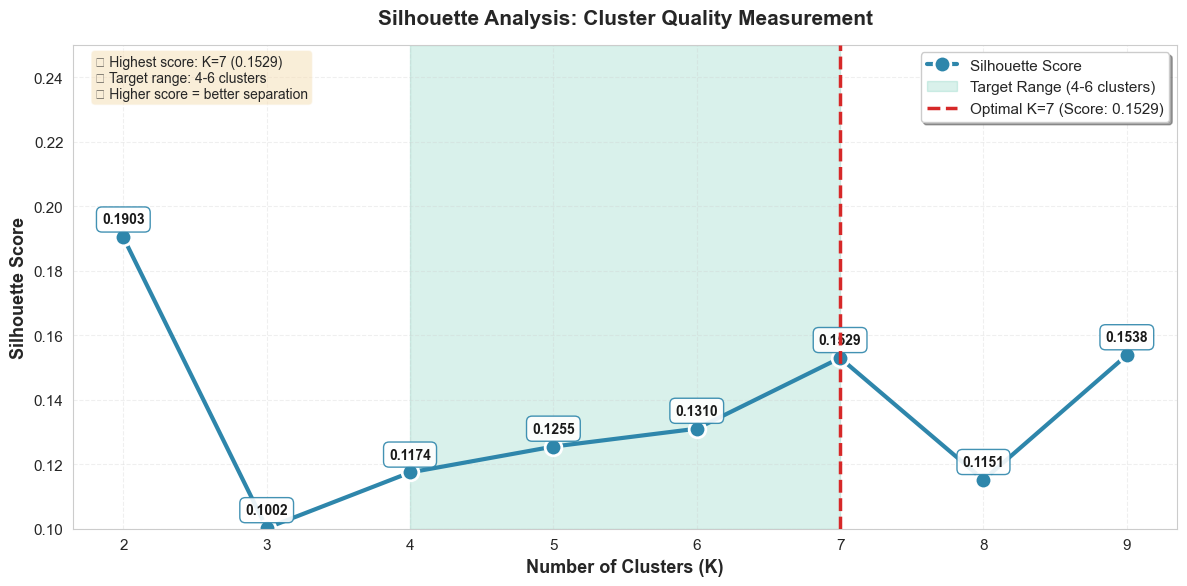


 Key Finding: K=7 shows best cluster separation (silhouette = 0.1529)


In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(results_df['k'], results_df['silhouette'], 'o-', 
        linewidth=3, markersize=12, color='#2E86AB', 
        label='Silhouette Score', markeredgecolor='white', markeredgewidth=2)

ax.axvspan(4, 7, alpha=0.15, color='#06A77D', 
          label='Target Range (4-6 clusters)', zorder=0)

optimal_score = results_df[results_df['k']==optimal_k]['silhouette'].values[0]
ax.axvline(x=optimal_k, color='#D62828', linestyle='--', linewidth=2.5, 
          label=f'Optimal K={optimal_k} (Score: {optimal_score:.4f})', zorder=5)

for idx, row in results_df.iterrows():
    ax.annotate(f'{row["silhouette"]:.4f}', 
                xy=(row['k'], row['silhouette']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=10, weight='bold', color='#1a1a1a',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                         edgecolor='#2E86AB', alpha=0.9))

ax.set_xlabel('Number of Clusters (K)', fontsize=13, weight='bold')
ax.set_ylabel('Silhouette Score', fontsize=13, weight='bold')
ax.set_title('Silhouette Analysis: Cluster Quality Measurement', 
            fontsize=15, weight='bold', pad=15)
ax.legend(loc='best', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_xticks(results_df['k'])
ax.set_ylim(bottom=0.10, top=0.25)

interpretation = (
    f"✓ Highest score: K={optimal_k} ({optimal_score:.4f})\n"
    f"✓ Target range: 4-6 clusters\n"
    f"✓ Higher score = better separation"
)
ax.text(0.02, 0.98, interpretation, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n Key Finding: K={optimal_k} shows best cluster separation (silhouette = {optimal_score:.4f})")

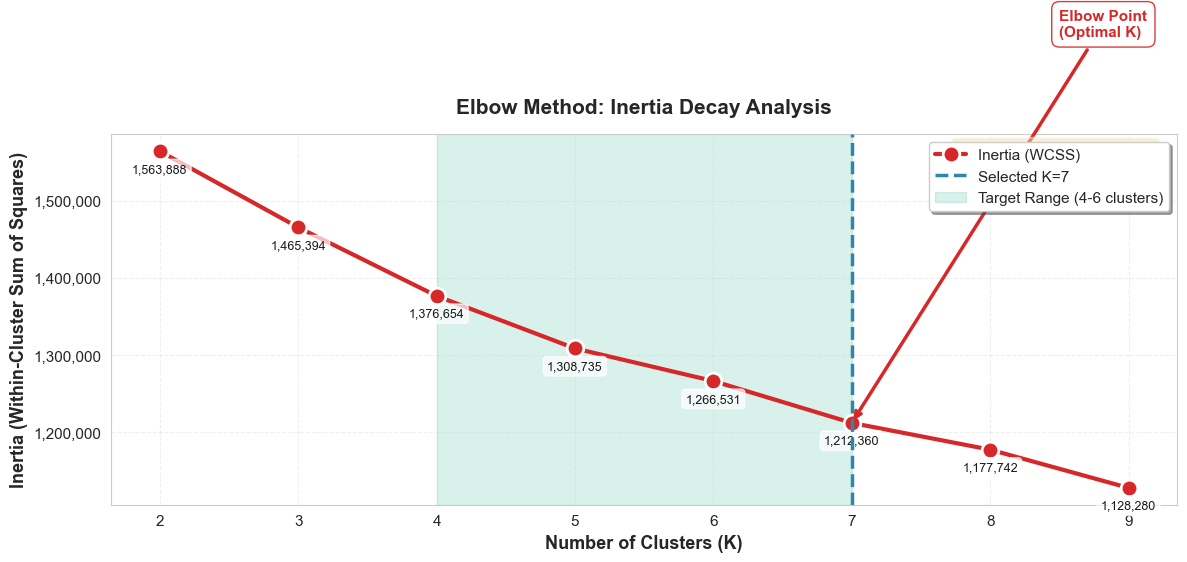


✅ ELBOW METHOD ANALYSIS COMPLETE

 Inertia Reduction by K:
   K=2 → K=3: 6.30% reduction
   K=3 → K=4: 6.06% reduction
   K=4 → K=5: 4.93% reduction
   K=5 → K=6: 3.22% reduction
   K=6 → K=7: 4.28% reduction
   K=7 → K=8: 2.86% reduction  ← Elbow
   K=8 → K=9: 4.20% reduction

 Key Finding: Inertia drops sharply until K=7, then plateaus


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot inertia values
ax.plot(results_df['k'], results_df['inertia'], 'o-', 
        linewidth=3, markersize=12, color='#D62828', 
        label='Inertia (WCSS)', markeredgecolor='white', markeredgewidth=2)

ax.axvline(x=optimal_k, color='#2E86AB', linestyle='--', linewidth=2.5, 
          label=f'Selected K={optimal_k}', zorder=5)

ax.axvspan(4, 7, alpha=0.15, color='#06A77D', 
          label='Target Range (4-6 clusters)', zorder=0)

elbow_k = optimal_k
elbow_inertia = results_df[results_df['k']==elbow_k]['inertia'].values[0]
ax.annotate('Elbow Point\n(Optimal K)', 
            xy=(elbow_k, elbow_inertia),
            xytext=(elbow_k+1.5, elbow_inertia + 500000),
            arrowprops=dict(arrowstyle='->', color='#D62828', lw=2.5),
            fontsize=11, weight='bold', color='#D62828',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='#D62828', alpha=0.9))

for idx, row in results_df.iterrows():
    ax.annotate(f'{row["inertia"]:,.0f}', 
                xy=(row['k'], row['inertia']),
                xytext=(0, -15), textcoords='offset points',
                ha='center', fontsize=9, color='#1a1a1a',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Number of Clusters (K)', fontsize=13, weight='bold')
ax.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=13, weight='bold')
ax.set_title('Elbow Method: Inertia Decay Analysis', 
            fontsize=15, weight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_xticks(results_df['k'])

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

interpretation = (
    f"✓ Clear elbow at K={optimal_k}\n"
    f"✓ Diminishing returns after K={optimal_k}\n"
    f"✓ Lower inertia = tighter clusters"
)
ax.text(0.98, 0.98, interpretation, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ ELBOW METHOD ANALYSIS COMPLETE")
print("="*80)

inertia_drops = []
for i in range(len(results_df)-1):
    current_inertia = results_df.iloc[i]['inertia']
    next_inertia = results_df.iloc[i+1]['inertia']
    drop_pct = 100 * (current_inertia - next_inertia) / current_inertia
    inertia_drops.append((results_df.iloc[i]['k'], results_df.iloc[i+1]['k'], drop_pct))

print(f"\n Inertia Reduction by K:")
for k_from, k_to, drop in inertia_drops:
    indicator = "  ← Elbow" if k_from == optimal_k else ""
    print(f"   K={int(k_from)} → K={int(k_to)}: {drop:.2f}% reduction{indicator}")

print(f"\n Key Finding: Inertia drops sharply until K={optimal_k}, then plateaus")